# Classification of Bat Hunting Calls

## Project by Johannes Maaß and Maja Gentsch


#### (Machine Learning Course, Prof. Vogel)

In [1]:
import librosa
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import io
import os

2025-12-09 20:18:26.934526: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-09 20:18:26.983385: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-09 20:18:27.985466: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


## Raw Data - EDA

In [28]:
import sqlite3
import pandas as pd
import matplotlib as plt

db_path = 'batcallsv14.db'

db_con = sqlite3.connect(db_path)
cursor = db_con.cursor()

n = cursor.execute("select count(*) from batcalls;")
print(f"Anzahl Einträge: {n.fetchone()[0]}")

head_df = pd.read_sql("select * from batcalls limit 10;", db_con)
head_df

Anzahl Einträge: 51719


,call,target,id,bat,arr,db
0,38818,0,0,Bartfledermaus,"b'\x93NUMPY\x01\x00v\x00{\'descr\': \'<i2\', \...",skiba
1,46731,0,1,Bartfledermaus,"b'\x93NUMPY\x01\x00v\x00{\'descr\': \'<i2\', \...",skiba
2,49137,0,2,Bartfledermaus,"b'\x93NUMPY\x01\x00v\x00{\'descr\': \'<i2\', \...",skiba
3,49557,0,3,Bartfledermaus,"b'\x93NUMPY\x01\x00v\x00{\'descr\': \'<i2\', \...",skiba
4,22197,0,4,Bartfledermaus,"b'\x93NUMPY\x01\x00v\x00{\'descr\': \'<i2\', \...",skiba
5,11958,0,5,Bartfledermaus,"b'\x93NUMPY\x01\x00v\x00{\'descr\': \'<i2\', \...",skiba
6,15446,0,6,Bartfledermaus,"b'\x93NUMPY\x01\x00v\x00{\'descr\': \'<i2\', \...",skiba
7,44262,0,7,Bartfledermaus,"b'\x93NUMPY\x01\x00v\x00{\'descr\': \'<i2\', \...",skiba
8,46273,0,8,Bartfledermaus,"b'\x93NUMPY\x01\x00v\x00{\'descr\': \'<i2\', \...",skiba
9,34856,0,9,Bartfledermaus,"b'\x93NUMPY\x01\x00v\x00{\'descr\': \'<i2\', \...",skiba


In [55]:
bat_names = pd.read_sql("select bat, count(*) as number from batcalls group by bat;", db_con)
bat_names.transpose()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
bat,Bartfledermaus,Bechsteinfledermaus,Breitflügelfledermaus,Fransenfledermaus,GroßerAbendsegler,GroßesMausohr,KleinerAbendsegler,Langohr,Mopsfledermaus,Mückenfledermaus,Nordfledermaus,Rauhautfledermaus,Rauschen,Teichfledermaus,Wasserfledermaus,Weißrandfledermaus,Wimperfledermaus,Zweifarbfledermaus,Zwergfledermaus
number,2393,329,2681,3040,3005,2366,2884,411,327,566,1245,4695,4713,2142,6074,4619,849,1495,7885


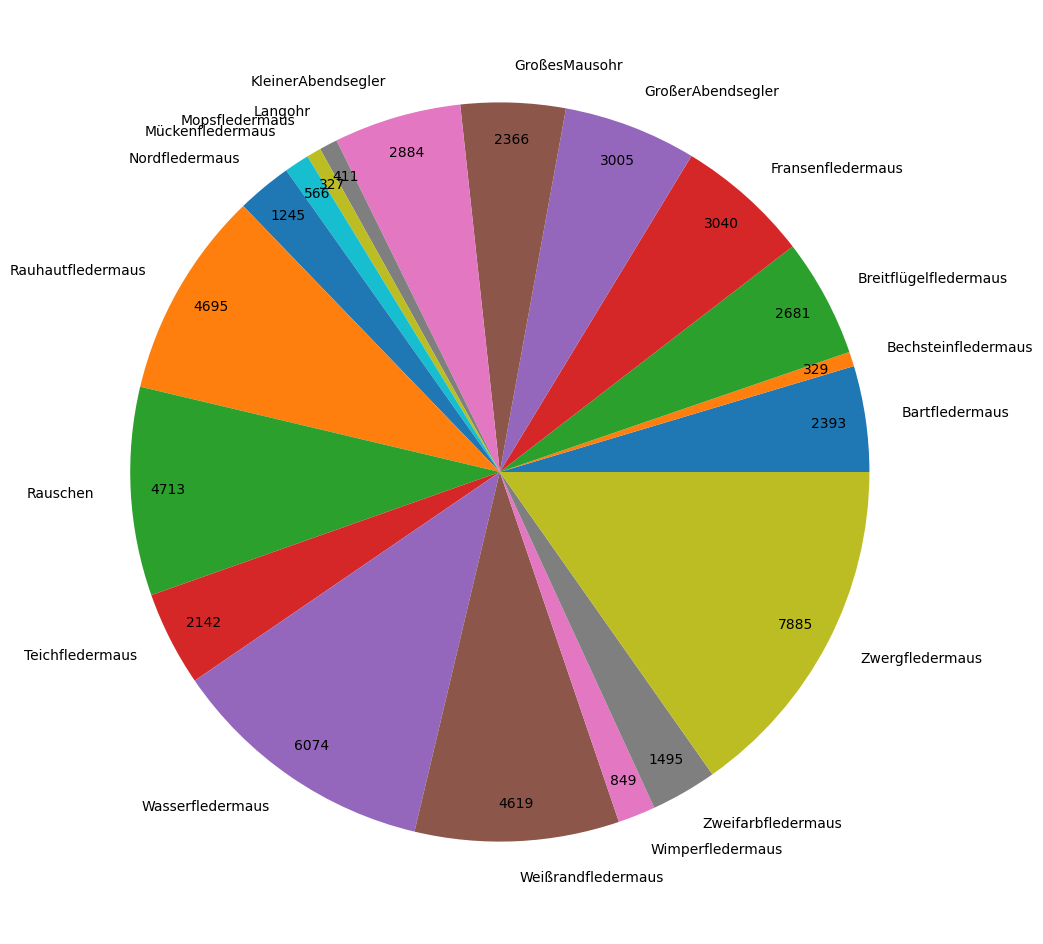

In [61]:
total = sum(bat_names['number'])
fig, ax = plt.subplots(figsize=(12,12))
ax.pie(bat_names['number'], labels=bat_names['bat'], 
       autopct=lambda p: '{:.0f}'.format(p * total / 100),
       pctdistance=0.9)
plt.show()

Wir haben einen Datensatz mit 51719 Einträgen mit folgenden Attributen:
- call: wahrscheinlich Nummerierung der Aufnahmen
- target: numerische Codierung der Klasse
- id: Tabellen-spezifische ID
- bat: nominaler Wert von Target (Bezeichnung der Fledermaus)
- arr: Aufnahmen der Jagdrufe
- db: ?

Insgesamt sind 19 verschiedene Fledermausarten aufgenommen worden.

## 0. Data Preprocessing

## 1. PCA

## 2. KNN

## 2. Decision Tree

## 2. Neural Net